# 1. Library Import & Data definition

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# quality와 err데이터의 train과 test set을 모두 import
# err_data는 quality_data의 fwver null processing에 사용

PATH = './data/'

train_err = pd.read_csv(PATH + 'train_err_data.csv')
train_qua = pd.read_csv(PATH + 'train_quality_data.csv')

test_err = pd.read_csv(PATH + 'test_err_data.csv')
test_qua = pd.read_csv(PATH + 'test_quality_data.csv')

In [3]:
# train_qua와 test_qua데이터에서 콤마(,)표시로 인해 문자로 표시된 변수를 숫자형 변수로 전환
train_qua['quality_5'] = train_qua['quality_5'].astype(str).str.replace(',','').astype(float)
train_qua['quality_7'] = train_qua['quality_7'].astype(str).str.replace(',','').astype(float)
train_qua['quality_8'] = train_qua['quality_8'].astype(str).str.replace(',','').astype(float)
train_qua['quality_9'] = train_qua['quality_9'].astype(str).str.replace(',','').astype(float)
train_qua['quality_10'] = train_qua['quality_10'].astype(str).str.replace(',','').astype(float)

test_qua['quality_1'] = test_qua['quality_1'].astype(str).str.replace(',','').astype(float)
test_qua['quality_5'] = test_qua['quality_5'].astype(str).str.replace(',','').astype(float)
test_qua['quality_7'] = test_qua['quality_7'].astype(str).str.replace(',','').astype(float)
test_qua['quality_8'] = test_qua['quality_8'].astype(str).str.replace(',','').astype(float)
test_qua['quality_9'] = test_qua['quality_9'].astype(str).str.replace(',','').astype(float)
test_qua['quality_10'] = test_qua['quality_10'].astype(str).str.replace(',','').astype(float)

In [4]:
# NULL EDA를 위해 train과 test데이터 통합
full_qua = pd.concat([train_qua, test_qua])

# 2. 통합 데이터 NULL EDA

In [5]:
# 전체 quality_data의 NULL값 확인
full_qua.isna().sum()

time               0
user_id            0
fwver          62844
quality_0     251016
quality_1         11
quality_2      61228
quality_3          0
quality_4          0
quality_5         64
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

quality_data에서 NULL값을 가지는 변수는 'fwver', 'quality_0', 'quality_1', 'quality_2', 'quality_5'이다. 'fwver'의 경우에는 err_data를 이용하여 NULL값을 처리할 수 있지만, 'quality_0, 1, 2, 5'의 경우에는 다른 변수 사이와 상관성을 파악하여 NULL값을 처리해야 한다.

특히 'quality_0, 1, 2, 5, 6, 11'은 0보다 아래인 음수 값을 가지는데, 연속적인 값이 아니라 -1이라는 값 하나로만 표현된다. 이를 통해 -1이라는 값은 장비의 특정한 상태(예시: quality_0을 기록하는 장비의 문제로 품질의 상태를 기록할 수 없는 상태)를 나타낸 것으로 보았다. 따라서 이와 같이 특정 변수에 -1값이 발생한 경우를 '-1패턴'이라 지칭하고, NULL EDA와 NULL processing에서 '-1패턴'인 경우와 아닌 경우를 모두 확인한다.

## 2.1. quality correlation

들어가기에 앞서 quality변수 사이의 상관관계를 아래와 같이 먼저 확인한다.

In [6]:
# null값과 -1값은 모두 제외하고 correlation을 계산
temp = full_qua.dropna()
temp = temp.loc[(temp['quality_0'] != -1) & (temp['quality_1'] != -1) & (temp['quality_2'] != -1) & 
                (temp['quality_5'] != -1) & (temp['quality_6'] != -1) & (temp['quality_11'] != -1), :]
temp.iloc[:, 3:].corr()

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
quality_0,1.000000,0.046760,0.997999,NaN,NaN,0.065589,-0.000219,0.000112,0.046357,0.567735,0.028646,0.015601,0.009709
quality_1,0.046760,1.000000,-0.000009,NaN,NaN,0.006549,0.000129,-0.000027,0.994424,-0.000035,0.007688,0.001562,0.001087
quality_2,0.997999,-0.000009,1.000000,NaN,NaN,0.065683,-0.000221,0.000108,-0.000119,0.568171,0.028897,0.015603,0.009710
quality_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_5,0.065589,0.006549,0.065683,NaN,NaN,1.000000,0.005261,0.007743,0.006895,0.036309,0.786975,0.076589,0.074130
quality_6,-0.000219,0.000129,-0.000221,NaN,NaN,0.005261,1.000000,0.819261,0.000364,0.000470,0.011029,0.002310,0.000329
quality_7,0.000112,-0.000027,0.000108,NaN,NaN,0.007743,0.819261,1.000000,0.000305,0.000593,0.013022,-0.000465,-0.000761
quality_8,0.046357,0.994424,-0.000119,NaN,NaN,0.006895,0.000364,0.000305,1.000000,-0.000238,0.008391,0.003682,0.009927
quality_9,0.567735,-0.000035,0.568171,NaN,NaN,0.036309,0.000470,0.000593,-0.000238,1.000000,0.041793,0.005776,0.010902


상관관계가 모두 NaN이 나온 'quality_3, 4'의 값을 아래와 같이 확인하여 본다.

In [7]:
print("-"*30)
print(temp['quality_3'].value_counts())
print("-"*30)
print(temp['quality_4'].value_counts())
print("-"*30)

------------------------------
0    1066415
Name: quality_3, dtype: int64
------------------------------
0    1066415
Name: quality_4, dtype: int64
------------------------------


'quality_3, 4'변수는 모두 0으로 이루어져 있기 때문에 NULL processing에서는 사용하지 않는다.

quality변수 사이의 상관관계를 시각화하면 다음과 같다.

In [8]:
temp.drop(['quality_3', 'quality_4'], axis = 1, inplace = True)

<AxesSubplot:>

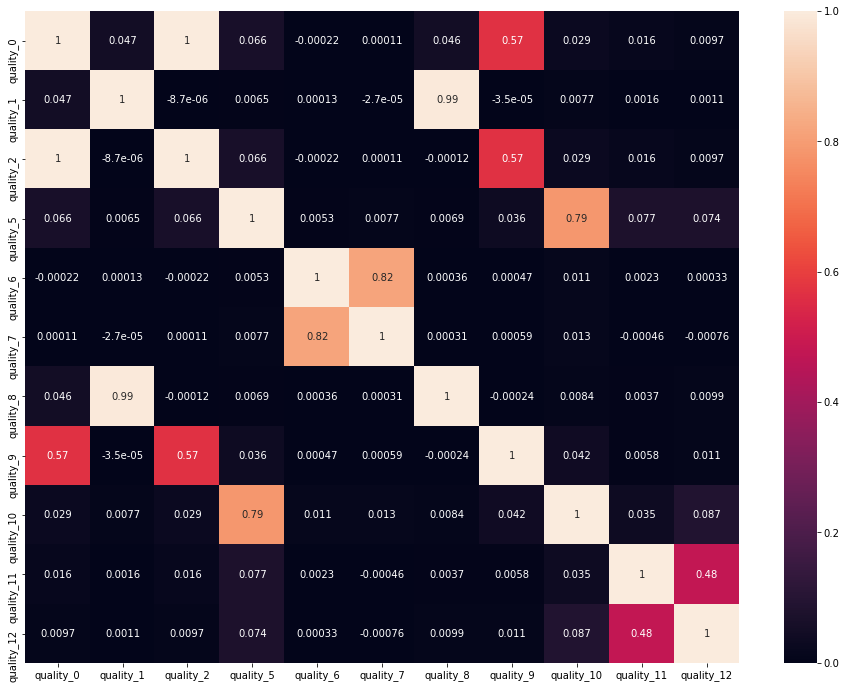

In [9]:
plt.figure(figsize = (16,12))
sns.heatmap(temp.iloc[:, 3:].corr(), annot = True)

NULL값을 가지는 quality 변수와 상관관계가 높은 변수들을 정리하면 다음과 같다.

| NULL을 가지는 quality변수 | 높은 상관관계를 가지는 quality변수 |
| :---: | :--- |
| **quality_0** | quality_2(0.997), qualtiy_9(0.567) |
| **quality_1** | qualtiy_8(0.994) |
| **quality_2** | quality_0(0.997), qualtiy_9(0.568) |
| **quality_5** | qualtiy_10(0.786) |
| * 괄호 안은 두 변수 사이의 상관관계를 뜻한다.|


'quality_0'과 'quality_2'의 상관관계는 높지만 둘다 NULL값이 존재하기 때문에, 두변수가 모두 NULL을 가지는 경우에 대한 NULL EDA를 먼저 진행한다. 그 후에 'quality_5'에 대한 NULL EDA를 차례로 진행한다.
\
('quality_1'에 대한 NULL EDA를 진행하지 않는 이유는 'quality_8'과의 상관관계가 거의 1에 가깝기 때문이다. 즉, 'quality_1'이 NULL을 가질 때 'quality_8' 값을 이용하여 NULL을 대치할 수 있다.)

## 2.2. quality_0, quality_2
'quality_0, 2'의 상관관계는 거의 1에 가깝기 때문에, 두 변수 모두 NULL을 가진 경우에 대한 EDA를 진행한다. 이때 'quality_0, 2'는 -1패턴을 가지는 변수임과 동시에 'quality_9'와의 상관관계가 0.56이다. 따라서 NULL EDA는 이 두가지를 중심으로 진행한다.

**<-1패턴 확인>**

In [10]:
# quality_0, 1, 2, 5, 6, 11은 모두 함께 -1패턴을 나타내는 경향을 보인다 
temp = full_qua.loc[(full_qua['quality_0'] == -1)|(full_qua['quality_2'] == -1), :]
temp

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
72,20201118001000,10002,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,3.0,-1,0
73,20201118001000,10002,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,3.0,-1,0
130,20201102232000,10004,04.22.1750,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,3.0,-1,0
131,20201102232000,10004,04.22.1750,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,3.0,-1,0
158,20201119040000,10005,04.22.1750,-1.0,-1.0,-1.0,0,0,-1.0,-1,36.0,0.0,0.0,4.0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747933,20201126011000,44996,04.22.1778,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,5.0,-1,0
747934,20201126011000,44996,04.22.1778,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,5.0,-1,0
747935,20201126011000,44996,04.22.1778,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,5.0,-1,0
747938,20201127111000,44996,04.22.1778,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,0.0,2.0,-1,0


위의 결과 테이블을 통해 'quality_0'또는 'quality_2'가 -1을 가질 때, 'quality_1, 5, 6, 11'도 함께 -1값을 가지는 경향을 확인할 수 있다. 이를 보다 자세히 알아보기 위해 각 변수가 가지는 모든 값을 아래에서 확인하여본다.

In [11]:
# quality_0 또는 quality_2가 NULL일 때의 -1패턴 확인
print("-"*30)
print(temp['quality_0'].value_counts())
print("-"*30)
print(temp['quality_1'].value_counts())
print("-"*30)
print(temp['quality_2'].value_counts())
print("-"*30)
print(temp['quality_5'].value_counts())
print("-"*30)
print(temp['quality_6'].value_counts())
print("-"*30)
print(temp['quality_11'].value_counts())
print("-"*30)

------------------------------
-1.0    257829
Name: quality_0, dtype: int64
------------------------------
-1.0    281225
 0.0        29
 2.0         2
Name: quality_1, dtype: int64
------------------------------
-1.0    281256
Name: quality_2, dtype: int64
------------------------------
-1.0      281235
 0.0          14
 244.0         2
 275.0         2
 1.0           2
Name: quality_5, dtype: int64
------------------------------
-1    281225
 0        29
 6         2
Name: quality_6, dtype: int64
------------------------------
-1    281225
 0        31
Name: quality_11, dtype: int64
------------------------------


위 결과를 통해 'quality_0'이나 'quality_2'가 -1을 가질 때 'quality_1, 5, 6, 11'도 함께 -1을 가지는 경향을 확인하였다. 따라서 'quality_1, 5, 6, 11'변수 중 -1패턴이 보이면, 'quality_0, 2'도 -1로 NULL값을 대치한다. 

**<quality_9와의 관계 확인>**

In [12]:
# quality_0, 2가 NULL값을 가질 때 quality_9가 어떤 값을 가지는지 확인
full_qua[(full_qua['quality_0'].isna()) & (full_qua['quality_2'].isna())]['quality_9'].value_counts()

0.0    61164
Name: quality_9, dtype: int64

'quality_0, 2'가 동시에 NULL값을 가질 때의 'quality_9'는 모두 0이라는 값을 가진다. 따라서 'quality_9'가 0을 가질 때 'quality_0, 2'가 어떤 값을 가지는지 역으로 탐색한다.

In [13]:
# quality_9가 0값을 가질 때 quality_0, 2가 어떤 값을 가지는지 확인
print("-"*30)
print(full_qua[full_qua['quality_9']==0]['quality_0'].value_counts())
print("-"*30)
print(full_qua[full_qua['quality_9']==0]['quality_2'].value_counts())
print("-"*30)

------------------------------
 0.0    1028579
-1.0     248425
Name: quality_0, dtype: int64
------------------------------
 0.0    1180299
-1.0     270525
Name: quality_2, dtype: int64
------------------------------


'quality_9'가 0일 때 'quality_0, 2'는 모두 0 또는 -1을 가진다. 위에서 탐색한 -1패턴 내용과 종합하여 보면, 다음과 같이 정리할 수 있다.
* 'quality_1, 5, 6, 11' 중 -1패턴이 하나라도 존재할때는 'quality_0, 2'의 NULL값을 -1로 대치한다.
* -1패턴이 보이지 않는 경우는 'quality_0, 2'의 NULL값을 0으로 대치한다

## 2.3. quality_5
'quality_5'는 'qualtiy_10'과 0.786이라는 상관관계를 가짐과 동시에 -1패턴을 보이는 변수이기 때문에, 이를 중심으로 NULL EDA를 진행한다.

**<-1패턴 확인>**

quality_5가 -1패턴을 가질 때, 대부분의 'quality_0, 1, 2, 6, 11'는 모두 -1을 가지는 것을 아래의 결과를 통해 확인할 수 있다.

In [14]:
# quality_5가 NULL일 때의 -1패턴 확인
temp = full_qua.loc[(full_qua['quality_5'] == -1), :]
print("-"*30)
print(temp['quality_0'].value_counts())
print("-"*30)
print(temp['quality_1'].value_counts())
print("-"*30)
print(temp['quality_2'].value_counts())
print("-"*30)
print(temp['quality_6'].value_counts())
print("-"*30)
print(temp['quality_11'].value_counts())
print("-"*30)

------------------------------
-1.0    257808
Name: quality_0, dtype: int64
------------------------------
-1.0    295106
 0.0        13
 1.0        11
 2.0        10
 3.0         1
 5.0         1
Name: quality_1, dtype: int64
------------------------------
-1.0    281235
Name: quality_2, dtype: int64
------------------------------
-1      295020
 1          24
 2          17
 0          13
 3          12
 4          10
 7           9
 5           8
 6           7
 11          4
 8           3
 10          3
 12          3
 9           3
 15          2
 18          1
 55          1
 86          1
 130         1
Name: quality_6, dtype: int64
------------------------------
-1    295131
 0        11
Name: quality_11, dtype: int64
------------------------------


**<quality_9와의 관계 확인>**

'quality_5'가 NULL을 가질 때, 'quality_10'은 아래와 같이 모두 매우 큰 값을 가진다. 

In [15]:
# quality_5가 NULL일때, quality_10이 가지는 값
full_qua[full_qua['quality_5'].isna()][['quality_10']].value_counts()

quality_10
1172849.0     3
1170195.0     3
1168491.0     3
1163224.0     3
1159867.0     3
1103961.0     3
1037689.0     2
1005588.0     2
1012799.0     2
1013708.0     2
1015637.0     2
1078598.0     2
1073366.0     2
1077718.0     2
843420.0      2
1078927.0     2
1086404.0     2
938660.0      2
781184.0      2
143329.0      1
790615.0      1
156060.0      1
159698.0      1
161367.0      1
161642.0      1
166060.0      1
175179.0      1
200496.0      1
212353.0      1
239516.0      1
283710.0      1
293913.0      1
497429.0      1
501073.0      1
501599.0      1
631620.0      1
673784.0      1
681199.0      1
114120.0      1
dtype: int64

In [16]:
min(full_qua[full_qua['quality_5'].isna()]['quality_10'])

114120.0

'quality_5'가 NULL일 때'quality_10'의 최솟값은 114,120으로 굉장히 큰 값을 가진다. 따라서 'quality_10'이 큰 값을 가질 때의 'quality_5'값을 역으로 확인해본다.

먼저 'quality_10'에 대한 내림차순 값을 확인해보자.

In [17]:
# quality_10에 대한 내림차순 테이블
full_qua.sort_values(by = ['quality_10'],  ascending=False).head(20)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
258732,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258743,20201125204000,14701,05.15.2138,5.0,0.0,5.0,0,0,637385.0,0,0.0,0.0,13.0,1910175.0,0,0
258741,20201125204000,14701,05.15.2138,3.0,0.0,3.0,0,0,635515.0,0,0.0,0.0,13.0,1910175.0,0,0
258740,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258739,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258738,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258737,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258736,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258735,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0
258734,20201125204000,14701,05.15.2138,-1.0,-1.0,-1.0,0,0,-1.0,-1,0.0,0.0,13.0,1910175.0,-1,0


위 결과를 보면, 한 유저당 2시간동안 발생한 'quality_5'와 'quality_10'의 변화량이 다른 것을 확인할 수 있다. 즉, quality_10은 2시간동안 계속 같은 값을 유지한 반면, 'quality_5'는 큰 변동을 가지고 값이 변화한 것을 확인할 수 있다. 특히 위의 결과에서 'quality_5'는 -1패턴과 큰 양수 값이 번갈아 나타나는 것을 확인할 수 있다.

이와 같이 서로 다른 변화량을 보이는 'quality_5, 10'의 관계를 확인해본다.

In [18]:
# quality_5와 quality_10의 시간에 따른 변화량 테이블
# user_id와 time에 따른 quality_5와 quality_10의 평균과 분산
table = full_qua.groupby(['user_id', 'time']).agg({'quality_5': ['mean', 'std'],
                                                   'quality_10': ['mean', 'std']})
table

quality_5           quality_10     
                            mean       std       mean  std
user_id time                                              
10000   20201129090000  0.333333  1.154701        4.0  0.0
        20201130210000  0.666667  2.309401        8.0  0.0
10002   20201104110000  0.000000  0.000000        0.0  0.0
        20201106010000  0.166667  0.577350        2.0  0.0
        20201111010000  0.333333  0.651339        4.0  0.0
...                          ...       ...        ...  ...
44996   20201125011000  0.750000  1.544786        9.0  0.0
        20201126011000  0.166667  1.337116        5.0  0.0
        20201127111000  0.000000  0.738549        2.0  0.0
44997   20201102214000  0.833333  1.114641       10.0  0.0
        20201125180000  0.250000  0.621582        3.0  0.0

[131214 rows x 4 columns]

In [19]:
# quality_5와 quality_10의 시간당 평균과 분산의 분포
table.describe()

quality_5                   quality_10               
                mean            std          mean            std
count  131214.000000  131214.000000  1.312140e+05  131214.000000
mean       73.754768     104.076586  8.451199e+02       0.000280
std      1638.752860    1521.753331  1.703877e+04       0.063157
min        -1.000000       0.000000  0.000000e+00       0.000000
25%         0.083333       0.668558  3.000000e+00       0.000000
50%         0.333333       1.154701  6.000000e+00       0.000000
75%         2.416667       3.785939  3.100000e+01       0.000000
max    159180.500000  287970.516187  1.910175e+06      20.905599

In [20]:
# quality_10의 std의 표준편차는 0.06으로 매우 작다.
# quality_10의 std가 어떤 값을 가지는지 확인
table['quality_10']['std'].value_counts()

0.000000     131210
4.596785          2
20.905599         1
6.639801          1
Name: std, dtype: int64

'quality_10'의 표준편차는 바로 위의 결과와 같이 대부분이 0이다. 이것이 의미하는 바는 품질이 기록이 시작된 2시간동안 'quality_10'은 계속 같은 값을 유지한다는 것이다. 그 반대로 'quality_5'의 표준편차의 평균이 'quality_10'보다 크게 나타나, 2시간동안의 변화량이 존재하는 것을 확인할 수 있다. 

그럼 'quality_10'이 100,000이상인 경우에 대해 'quality_5, 10'의 산점도로 두 변수의 상관관계를 확인해본다.

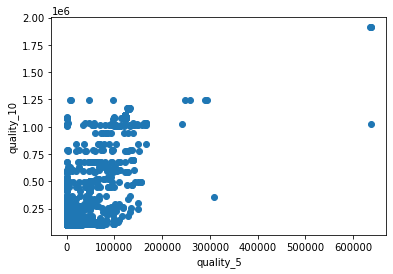

In [21]:
temp = full_qua.loc[(full_qua['quality_10']>=100000)&(full_qua['quality_5']!=-1), :][['quality_5', 'quality_10']]

plt.scatter(temp['quality_5'], temp['quality_10'])
plt.xlabel("quality_5")
plt.ylabel("quality_10")
plt.show()

위 산점도를 통해 'quality_10'이 클수록 'quality_5'도 큰 값을 가지는 것을 확인할 수 있다. 하지만 같은 'quality_10'을 가지더라도 'quality_5'의 분산이 크기 때문에, 유저당 품질이 기록된 2시간동안 발생한 'quality_5'의 평균으로 NULL값을 대치한다. 

# 3. NULL processing
NULL processing은 각 변수에 대해 다음과 같이 진행된다.

**fwver(err_data이용)**
* fwver에 결측이 있는 user_id별로 사용한 fwver 횟수를 구한다.
* 사용한 fwver 수가 1개라면, 해당 fwver값으로 대치한다.
* 만약 fwver 수가 여러개라면, err_data에 기록된 time과 quality_data에 기록된 time차이가 가장 적은 fwver을 선택하여 대치한다.


**quality_0, quality_2**
* quality_0, 2의 상관관계는 0.99로 거의 동일하다.
* quality_0, 2가 동시에 결측인 경우에는 -1패턴을 따르는지 여부를 확인한 후 다음과 같이 대치를 진행한다.
    - -1패턴이 보이는 경우, quality_0, 2도 -1로 대치한다.
    - -1패턴이 보이지 않는 경우 0으로 대치한다.
* quality_0가 결측이고 quality_2에 값이 있으면 quality_2의 값으로 대치하고, 그 반대의 경우는 quality_0으로 quality_2의 결측을 대치한다 대치한다.


**quality_1**
* quality_8과의 상관관계가 0.99로 높게 나타났기 때문에, quality_8을 이용하여 결측을 처리한다.
* quality_1도 -1패턴을 가지는 변수지만 NULL값을 가지는 row 중에서 -1패턴을 다지는 다른 quality변수가 존재하지 않았다. 따라서 -1패턴을 확인하지 않고 바로 quality_8을 이용해 NULL 대치를 진행하였다.


**quality_5**
* quality_5와 quality_10의 상관관계가 큰데, 실제로 quality_10이 클 때 결측이 발생하는 것을 확인할 수 있다.
* quality_10이 큰 경우에 quality_5는 다음 두가지 패턴을 보인다.
    - quality_0, 1, 2, 6, 11에서 -1패턴이 보이는 경우 quality_5도 -1로 대치한다.
    - -1 패턴이 없는 경우 quality_5도 매우 큰 값을 가지지만 계속 변화하는 값을 가지기 때문에, `quality_data.groupby('quality_10')['quality_5'].mean()`으로 대치한다. (이때 quality_10으로 그룹짓는 이유는 quality_10 데이터는 품질기록시간인 2시간동안 계속 같은 값이 유지가 되는 특성이 있으며, 큰 값들은 유저와 품질 기록 시간이 유일하게 존재하기 때문이다.)


## 3.1. train_quality_data NULL processing

In [22]:
train_qua.isna().sum() #fwver, quality_0, 2, 5에 결측 존재

time               0
user_id            0
fwver          40080
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### fwver

In [23]:
#fwna_id는 train_quality에서 fwver에 결측을 가진 user_id 모음
#fw_n은 train err에서 각 user_id별로 사용한 fwver횟수
fwna_id = train_qua[train_qua['fwver'].isna()].user_id.unique()
fw_n = train_err.groupby('user_id')[['fwver']].nunique()

In [24]:
#fwna_id중에서 두개 이상의 fwver를 사용하는 user_id의 수 반환
#두명빼고는 다 fwver 하나만 가지고 있음
result = len(fwna_id)
for i in fwna_id:
    if fw_n.iloc[i-10000, 0] == 1: result -= 1
result

2

In [25]:
#fwna_id중에서 두개 이상의 fwver를 사용하는 user_id 반환
result = []
for i in fwna_id:
    if fw_n.iloc[i-10000, 0] != 1: result.append(i)
result

[15680, 16730]

In [26]:
fwna2_id = set(result)
fwna1_id = set(fwna_id) - fwna2_id
#fwna1_id, fwna2_id

In [27]:
#fwver을 하나만 가지는 user에 대한 결측값 대입
temp = train_qua
for i in fwna1_id:
    imputation_value = train_err[train_err['user_id']==i]['fwver'].unique()[0]
    temp.loc[temp['user_id']==i, 'fwver'] = imputation_value

In [28]:
#fwver을 두개 이상 가지는 user에 대한 결측값 대입
for i in fwna2_id:
    err_time_list = list(train_err[train_err['user_id']==i]['time'].unique())
    qua_time_list = list(train_qua[(train_qua['user_id']==i) & (train_qua['fwver'].isna())]['time'].unique())
    
    for time in qua_time_list:
        time_diff = [abs(x-time) for x in err_time_list]
        idx = time_diff.index(min(time_diff))
        closest_time = err_time_list[idx]
        imputation_value = train_err[(train_err['user_id']==i) & (train_err['time']==closest_time)]['fwver'].unique()[0]
        temp.loc[(temp['user_id']==i) & (temp['time']==time), 'fwver'] = imputation_value
temp.isna().sum()

time               0
user_id            0
fwver              0
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### quality_5

In [29]:
# -1패턴이 나타난 경우 -1로 대치
temp.loc[(temp['quality_0']==-1) & (temp['quality_1']==-1) & (temp['quality_2']==-1) & 
         (temp['quality_6']==-1) & (temp['quality_11']==-1) & (temp['quality_5'].isna()), 
         'quality_5'] = -1

In [30]:
# -1패턴이 나타나지 않은 경우 같은 quality_10을 가지는 quality_5로 대치
temp1 = train_qua.loc[(train_qua['quality_10']>=100000)&(train_qua['quality_5']!=-1), :][['quality_5', 'quality_10']]
imputation_list = temp1.groupby('quality_10')[['quality_5']].mean()
na_idx = temp[temp['quality_5'].isnull()].index.tolist()

for i in na_idx:
    imputation_value = imputation_list.loc[temp.loc[i, 'quality_10'], 'quality_5']
    temp.loc[i, 'quality_5'] = imputation_value
temp.isna().sum()

time               0
user_id            0
fwver              0
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5          0
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### quality_0, 2

In [31]:
# quality_0, 2가 동시에 결측인 경우
temp.loc[((temp['quality_2'].isna()) & (temp['quality_0'].isna())) & 
    ((temp['quality_1']==-1) | (temp['quality_5']==-1) | 
    (temp['quality_6']==-1) | (temp['quality_11']==-1)), 'quality_0'] = -1
temp.loc[((temp['quality_2'].isna()) & (temp['quality_0']==-1)) & 
    ((temp['quality_1']==-1) | (temp['quality_5']==-1) | 
    (temp['quality_6']==-1) | (temp['quality_11']==-1)), 'quality_2'] = -1

temp.loc[(temp['quality_2'].isna()) & (temp['quality_0'].isna()), 'quality_0'] = 0
temp.loc[(temp['quality_2'].isna()), 'quality_2'] = 0

In [32]:
# quality_0, 2 중 하나만 결측인 경우
na0_idx = set(temp[temp['quality_0'].isnull()].index.tolist())
na2_idx = set(temp[temp['quality_2'].isnull()].index.tolist())
na0_idx = na0_idx - na2_idx
na2_idx = na2_idx - na0_idx

for i in tqdm(na0_idx):
    temp.loc[i, 'quality_0'] = temp.loc[i, 'quality_2']
    
for i in tqdm(na2_idx):
    temp.loc[i, 'quality_2'] = temp.loc[i, 'quality_0']

100%|█████████████████████████████████████████████████████████████████████████| 104352/104352 [07:07<00:00, 244.03it/s]
0it [00:00, ?it/s]


In [33]:
temp.isna().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

### save the processing data

In [34]:
temp.to_csv(PATH+"train_quality_postnull_.csv", index = False)

In [35]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       828624 non-null  object 
 3   quality_0   828624 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   828624 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828624 non-null  float64
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  float64
 11  quality_8   828624 non-null  float64
 12  quality_9   828624 non-null  float64
 13  quality_10  828624 non-null  float64
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(7), int64(8), object(1)
memory usage: 101.2+ MB


## 3.2. test_quality_data NULL processing

In [36]:
test_qua.isna().sum() #fwver, quality_0, 1 2, 5에 결측 존재

time               0
user_id            0
fwver          22764
quality_0     106584
quality_1         11
quality_2      21115
quality_3          0
quality_4          0
quality_5         44
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### fwver

In [37]:
#fwna_id는 test_quality에서 fwver에 결측을 가진 user_id 모음
#fw_n은 test err에서 각 user_id별로 사용한 fwver횟수
fwna_id = test_qua[test_qua['fwver'].isna()].user_id.unique()
fw_n = test_err.groupby('user_id')[['fwver']].nunique()

In [38]:
#fwna_id중에서 두개 이상의 fwver를 사용하는 user_id의 수 반환
#다섯명빼고는 다 fwver 하나만 가지고 있음
result = len(fwna_id)
for i in fwna_id:
    if fw_n.iloc[i-30000, 0] == 1: result -= 1
result

5

In [39]:
#fwna_id중에서 두개 이상의 fwver를 사용하는 user_id 반환
result = []
for i in fwna_id:
    if fw_n.iloc[i-30000, 0] != 1: result.append(i)
result

[36160, 39078, 44056, 44817, 44903]

In [40]:
#test_err데이터에서 43262만 데이터가 없음 -> fwver을 43261걸로 대치함
set(range(30000, 44999))-set(test_err['user_id'])

{43262}

In [41]:
imputation_value = test_err[test_err['user_id']==43261]['fwver'].unique()[0]
test_qua.loc[test_qua['user_id']==43262, 'fwver'] = imputation_value

In [42]:
fwna2_id = set(result)
fwna1_id = set(fwna_id) - fwna2_id - {43262}
#fwna1_id, fwna2_id

In [43]:
#fwver을 하나만 가지는 user에 대한 결측값 대입
temp = test_qua
for i in fwna1_id:
    imputation_value = test_err[test_err['user_id']==i]['fwver'].unique()[0]
    temp.loc[temp['user_id']==i, 'fwver'] = imputation_value

In [44]:
#fwver을 두개 이상 가지는 user에 대한 결측값 대입
for i in fwna2_id:
    err_time_list = list(test_err[test_err['user_id']==i]['time'].unique())
    qua_time_list = list(test_qua[(test_qua['user_id']==i) & (test_qua['fwver'].isna())]['time'].unique())
    
    for time in qua_time_list:
        time_diff = [abs(x-time) for x in err_time_list]
        idx = time_diff.index(min(time_diff))
        closest_time = err_time_list[idx]
        imputation_value = test_err[(test_err['user_id']==i) & (test_err['time']==closest_time)]['fwver'].unique()[0]
        temp.loc[(temp['user_id']==i) & (temp['time']==time), 'fwver'] = imputation_value
temp.isna().sum()

time               0
user_id            0
fwver              0
quality_0     106584
quality_1         11
quality_2      21115
quality_3          0
quality_4          0
quality_5         44
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### quality_5

In [45]:
# test데이터에서 quality_5가 NULL인 경우에 주변 변수에서 -1패턴을 가지는 경우가 없다.
# -1패턴이 나타나지 않은 경우 같은 quality_10을 가지는 quality_5로 대치
temp1 = test_qua.loc[(test_qua['quality_10']>=100000)&(test_qua['quality_5']!=-1), :][['quality_5', 'quality_10']]
imputation_list = temp1.groupby('quality_10')[['quality_5']].mean()
na_idx = temp[temp['quality_5'].isnull()].index.tolist()

for i in na_idx:
    imputation_value = imputation_list.loc[temp.loc[i, 'quality_10'], 'quality_5']
    temp.loc[i, 'quality_5'] = imputation_value
temp.isna().sum()

time               0
user_id            0
fwver              0
quality_0     106584
quality_1         11
quality_2      21115
quality_3          0
quality_4          0
quality_5          0
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

### quality_0, 2

In [46]:
# quality_0, 2 중 하나만 결측인 경우
na0_idx = set(temp[temp['quality_0'].isnull()].index.tolist())
na2_idx = set(temp[temp['quality_2'].isnull()].index.tolist())
na0_idx = na0_idx - na2_idx
na2_idx = na2_idx - na0_idx

for i in tqdm(na0_idx):
    temp.loc[i, 'quality_0'] = temp.loc[i, 'quality_2']
    
for i in tqdm(na2_idx):
    temp.loc[i, 'quality_2'] = temp.loc[i, 'quality_0']

100%|███████████████████████████████████████████████████████████████████████████| 21115/21115 [01:16<00:00, 275.84it/s]


In [47]:
len(na0_idx), len(na2_idx)

(85500, 21115)

In [48]:
# quality_0, 2가 동시에 결측인 경우
temp.loc[((temp['quality_2'].isna()) & (temp['quality_0'].isna())) & 
    ((temp['quality_1']==-1) | (temp['quality_5']==-1) | 
    (temp['quality_6']==-1) | (temp['quality_11']==-1)), 'quality_0'] = -1
temp.loc[((temp['quality_2'].isna()) & (temp['quality_0']==-1)) & 
    ((temp['quality_1']==-1) | (temp['quality_5']==-1) | 
    (temp['quality_6']==-1) | (temp['quality_11']==-1)), 'quality_2'] = -1

temp.loc[(temp['quality_2'].isna()) & (temp['quality_0'].isna()), 'quality_0'] = 0
temp.loc[(temp['quality_2'].isna()), 'quality_2'] = 0

temp.isna().sum()

time           0
user_id        0
fwver          0
quality_0      0
quality_1     11
quality_2      0
quality_3      0
quality_4      0
quality_5      0
quality_6      0
quality_7      0
quality_8      0
quality_9      0
quality_10     0
quality_11     0
quality_12     0
dtype: int64

### quality_1

In [49]:
# quality_8과의 상관관계가 0.99이며, quality_1이 NULL일 때 주변 변수에서 -1패턴을 보이지 않는다.
# quality_8을 이용해 NULL 대치
na1_idx = set(temp[temp['quality_1'].isnull()].index.tolist())

for i in tqdm(na1_idx):
    temp.loc[i, 'quality_1'] = temp.loc[i, 'quality_8']

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 261.84it/s]


### save the processing data

In [50]:
temp.to_csv(PATH+"test_quality_postnull_.csv", index = False)

In [51]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        747972 non-null  int64  
 1   user_id     747972 non-null  int64  
 2   fwver       747972 non-null  object 
 3   quality_0   747972 non-null  float64
 4   quality_1   747972 non-null  float64
 5   quality_2   747972 non-null  float64
 6   quality_3   747972 non-null  int64  
 7   quality_4   747972 non-null  int64  
 8   quality_5   747972 non-null  float64
 9   quality_6   747972 non-null  int64  
 10  quality_7   747972 non-null  float64
 11  quality_8   747972 non-null  float64
 12  quality_9   747972 non-null  float64
 13  quality_10  747972 non-null  float64
 14  quality_11  747972 non-null  int64  
 15  quality_12  747972 non-null  int64  
dtypes: float64(8), int64(7), object(1)
memory usage: 91.3+ MB
